In [85]:
import httpx
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup
from time import sleep
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import TimeoutException, NoSuchElementException


def get_ab_key(url):
    # 发送GET请求并解析页面内容
    response = httpx.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    result = {}

    # 提取作者
    author_info_list = soup.find_all('h3', class_='author')
    author_info = author_info_list[0]  # 第一个 <h3> 元素包含作者信息
    author_names = [span.get_text(strip=True) for span in author_info.find_all('span')] if author_info else []
    result['作者'] = '; '.join(author_names)

    # 提取作者单位
    school_info = author_info_list[1]  if len(author_info_list) > 1 else None # 第二个 <h3> 元素包含学校信息
    school_names = [span.get_text(strip=True) for span in school_info.find_all('a')] if school_info else []
    result['作者单位'] = '; '.join(school_names)

    # 提取摘要
    abstract_tag = soup.find('span', {'id': 'ChDivSummary'})
    abstract = abstract_tag.get_text(strip=True) if abstract_tag else ""
    result['摘要'] = abstract

    # 提取关键词
    keywords_tag = soup.find('p', {'class': 'keywords'})
    keywords = keywords_tag.get_text(separator='; ', strip=True) if keywords_tag else ""
    result['关键词'] = keywords.replace(';;', ';')

    # 提取基金资助
    fund_tag = soup.find('p', {'class': 'funds'})
    fund = fund_tag.get_text(separator='; ', strip=True) if fund_tag else ""
    result['基金资助'] = fund.replace('; ', '')

    # 提取 "DOI", "专辑", "分类号" 的内容
    album_tag = soup.find('span', string='专辑：')
    special_tag = soup.find('span', string='专题：')
    classification_number_tag = soup.find('span', string='分类号：')

    album = album_tag.find_next('p').text.strip() if album_tag else ""
    special = special_tag.find_next('p').text.strip() if special_tag else ""
    classification_number = classification_number_tag.find_next('p').text.strip() if classification_number_tag else ""

    result['专辑'] = album
    result['专题'] = special
    result['分类号'] = classification_number

    return result

def get_source_tag(url):
    response = httpx.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    journal_type = soup.find('p', class_='journalType journalType2')
    source_tag = journal_type.get_text(separator=' ',strip=True) if journal_type else ""
    return source_tag.replace(' ', '; ')

    
def wait_and_click(locator, timeout=10):
    try:
        element = WebDriverWait(driver, timeout).until(
            EC.element_to_be_clickable(locator)
        )
        element.click()
    except TimeoutException:
        print(f"元素 {locator} 在 {timeout} 秒内未变为可点击状态")
    except NoSuchElementException:
        print(f"未找到元素 {locator}")

def init():
    search_url = 'https://www.cnki.net/'
    search_term = '南京邮电大学'
    driver.get(search_url)
    driver.maximize_window()

    # 等待搜索框变得可交互并输入搜索词
    wait_and_click((By.ID, 'txt_SearchText'))
    search_box = driver.find_element(By.ID, 'txt_SearchText')
    search_box.send_keys(search_term)

    # 选择"作者单位"
    wait_and_click((By.XPATH, '//*[@id="DBFieldBox"]/div[1]'))
    wait_and_click((By.XPATH, '//*[@id="DBFieldList"]/ul/li[9]/a'))
    sleep(5)

    # 点击搜索按钮
    wait_and_click((By.CSS_SELECTOR, 'body>div.wrapper>div.searchmain>div.search-form>div.input-box>input.search-btn'))

    # 点击被引按钮
    # wait_and_click((By.XPATH, '//*[@id="CF"]'))

    sleep(2)
    # 找到包含"50"选项的div元素并点击
    wait_and_click((By.ID, 'perPageDiv'))
    wait_and_click((By.CSS_SELECTOR, 'li[data-val="50"]'))

def get_one_page(index):
    # 找到tbody元素
    try:
        tbody = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.TAG_NAME, 'tbody'))
        )
    except TimeoutException:
        print("页面加载超时,无法找到 tbody 元素")
        return []

    # 获取所有tr元素
    rows = tbody.find_elements(By.TAG_NAME, 'tr')

    literature_data = []
    error_list = []
    for literature in tqdm(rows, desc=f'提取第{index}页:'):
        try:
            # 提取题名、URL、作者等信息
            title_tag = literature.find_element(By.CSS_SELECTOR, '.name a')
            title = title_tag.text or ''
            url = title_tag.get_attribute('href') or ''
            # author = literature.find_element(By.CSS_SELECTOR, '.author').text or ''
            source_item = literature.find_element(By.CSS_SELECTOR, '.source')
            source = source_item.text or ''
            surce_child = source_item.find_element(By.CSS_SELECTOR, 'a') or ''
            surce_url = surce_child.get_attribute('href') or '' if surce_child else ''
            date = literature.find_element(By.CSS_SELECTOR, '.date').text or ''
            # data = literature.find_element(By.CSS_SELECTOR, '.data').text or ''
            # quote = literature.find_element(By.CSS_SELECTOR, '.quote').text or ''
            
            # 获取摘要和关键词等
            page_result = get_ab_key(url)
            source_tag = get_source_tag(surce_url)
        
            info = {
                '来源': source,
                '来源标签': source_tag,
                '发表日期': date,
                '题名': title,
                '作者': page_result['作者'],
                '作者单位': page_result['作者单位'],
                '摘要': page_result['摘要'], 
                '关键词': page_result['关键词'], 
                '基金资助': page_result['基金资助'], 
                '专辑': page_result['专辑'], 
                '专题': page_result['专题'], 
                '分类号': page_result['分类号'],
                # '数据库类型': data,
                # '被引用次数': quote
                'URL': url,
                "Source URL": surce_url,
            }
            # info.update(page_result)
            # info.update(source_tag)
            # print(f'{title} 添加完成')
            
            literature_data.append(info)
        except NoSuchElementException:
            error_list.append(f"第{index}页: 无法提取`{title}`的部分信息")
            continue

    return literature_data, error_list

In [72]:
driver = webdriver.Edge()
init()
literature_info = []
error_list = []

In [74]:

for num in range(120):
    page_data, page_error = get_one_page(num+1)
    if not page_data:
        break
    literature_info += page_data
    error_list += page_error

    # 获取当前焦点元素并发送右方向键
    try:
        element = driver.switch_to.active_element
        element.send_keys(Keys.ARROW_RIGHT)
        sleep(3)
    except Exception as e:
        print(f"发送右方向键失败: {e}")
        break

    # print(f'{num}_', end = '')

driver.quit()
print('\n'.join(error_list))

df = pd.DataFrame(literature_info)
df.to_csv('literature_info.csv', index=False, encoding='utf-8-sig')

df.head(5)


100%|██████████| 120/120 [14:20<00:00,  7.17s/it]


第9页: 无法提取`一种利用正交性抑制高次模的宽阻带矩形波导准椭圆滤波器`的部分信息


,来源,来源标签,发表日期,题名,作者,作者单位,摘要,关键词,基金资助,专辑,专题,分类号,URL,Source URL
0,财经论丛,,2024-08-12 17:19,人工智能应用如何影响制造企业创新绩效？,,,,,,,,,https://kns.cnki.net/kcms2/article/abstract?v=...,https://kns.cnki.net/knavi/journals/CJLC/detai...
1,科技与经济,,2024-08-12 16:48,长三角城市群绿色创新效率的时空特征及动态演进,,,,,,,,,https://kns.cnki.net/kcms2/article/abstract?v=...,https://kns.cnki.net/knavi/journals/KJYZ/detai...
2,信息资源管理学报,,2024-08-12 16:26,数据生产:概念、场景、技术与审思?,,,,,,,,,https://kns.cnki.net/kcms2/article/abstract?v=...,https://kns.cnki.net/knavi/journals/XNZY/detai...
3,激光与光电子学进展,,2024-08-12 10:00,基于交叉融合Transformer的红外与可见光图像融合方法,,,,,,,,,https://kns.cnki.net/kcms2/article/abstract?v=...,https://kns.cnki.net/knavi/journals/JGDJ/detai...
4,公关世界,,2024-08-12,先孵化后融合：社区治理中支持型社会组织的功能及其实现,,,,,,,,,https://kns.cnki.net/kcms2/article/abstract?v=...,https://kns.cnki.net/knavi/journals/GGSJ/detai...


In [79]:
df.to_csv('literature_info(8-13-5).csv', index=False, encoding='utf-8-sig')

In [92]:
error_list = []

for index in tqdm(range(6000)):
    url = df.loc[index, 'URL']
    source_url = df.loc[index, 'Source URL']

    if url:
        page_result = get_ab_key(url)
        df.loc[index, '作者'] = page_result['作者']
        df.loc[index, '作者单位'] = page_result['作者单位']
        df.loc[index, '摘要'] = page_result['摘要']
        df.loc[index, '关键词'] = page_result['关键词']
        df.loc[index, '基金资助'] = page_result['基金资助']
        df.loc[index, '专辑'] = page_result['专辑']
        df.loc[index, '专题'] = page_result['专题']
        df.loc[index, '分类号'] = page_result['分类号']
    if source_url:
        source_tag = get_source_tag(source_url)
        df.loc[index, '来源标签'] = source_tag

    break

  0%|          | 0/6000 [00:00<?, ?it/s]


IndexError: list index out of range

In [95]:
url = df.loc[0, "URL"]

url

'https://kns.cnki.net/kcms2/article/abstract?v=5YEXlE_hGrzoYkvJpVTB9hmGQ6GmYZG8YYhBww5APS6WASjRDAYyjQ3Gw-2_04GKemvwnUzd6cncBHYHHN4od9hi8K43I7z1AFNx2lCxyeHzCwKtv8Iu0lwNgm2w5o8-kaKDV9uxcHWyD_2WOvW7BnBtf8v3fvxgpfi8rrgCnZgnu3bMoqjiBok-QOp6XIwdWL-ncr0gFXt_JhC_yODVtQ==&uniplatform=NZKPT&language=CHS'

In [101]:
print(httpx.get('https://kns.cnki.net/kcms2/article/abstract?v=5YEXlE_hGrzhAh21kdiG1tu3YNCorvr4x8NRj2JwHmdxLGV3WG63cMQFAXy97zC0llOHsyXEqz0vrxIkz3DlJL6IK6GqvYvx6wS1Pm31I-0ykhCd_tHscgD5z2SuKoY3yVgC9VaVVRRhhhwm1yBUA64B3jmi1QCXnCxAMVbs1I79nOZ0yltDQaPalZ9slzuHsKoh7VqSeJUpdJAApaine-OGwnVpx1qRJ89ArIqmYuGHfX1CeGfXcw==&uniplatform=NZKPT&language=CHS').text)

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width,initial-scale=1,user-scalable=0">
    <meta name="apple-mobile-web-app-capable" content="yes">
    <meta name="apple-mobile-web-app-status-bar-style" content="black-translucent">
    <meta name="format-detection" content="telephone=no">
    <meta name="format-detection" content="telephone=no">
    <meta name="format-detection" content="email=no">
    <meta name="msapplication-tap-highlight" content="no"/>
    <title>人工智能应用如何影响制造企业创新绩效？ - 中国知网</title>
    <link rel="shortcut icon" href="https://piccache.cnki.net/nxgp/kcms/20240813r/images/gb/kcms8/favicon.ico" type="image/x-icon"/>
    <link rel="stylesheet" type="text/css" href="https://piccache.cnki.net/nxgp/kcms/20240813r/css/gb/kcms8/layout3.css">
    <link rel="stylesheet" type="text/css" href="https://piccache.cnki.net/nxgp/kcms/20240813r/css/gb/kcms8/public.css">
    <link rel="stylesheet" type="text/css" href=

In [99]:
get_ab_key(url)

IndexError: list index out of range

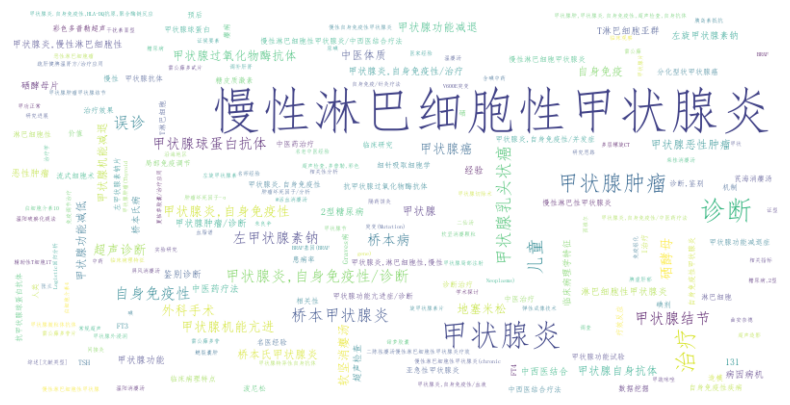

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 读取CSV文件
file_path = 'literature_info.csv'
df = pd.read_csv(file_path)

# 提取关键词列并统计频率
keywords = df['关键词'].dropna().str.replace(';', '').str.split()
all_keywords = [keyword for sublist in keywords for keyword in sublist]
keyword_counts = Counter(all_keywords)

# 上传字体文件后，指定字体路径
uploaded_font_path = r'C:\Windows\Fonts\simfang.ttf'

# 生成词云图
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=uploaded_font_path).generate_from_frequencies(keyword_counts)

# 显示词云图
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('literature_info.png')
plt.show()
